# Question

Implement a circuit that returns |01> and |10> with equal probability.
Requirements :
The circuit should consist only of CNOTs, RXs and RYs. 
Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
You should find the right set of parameters using gradient descent (you might use more advanced optimization methods if you like). 
Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

Bonus question:
How to make sure you produce state |01> + |10> and not |01> - |10> ?


# Idea

With some math magic, we know that the state can be prepared with the following set of operations

$$ (R_X(\pi) \otimes R_X(\pi)) * (R_Y(-\pi/2) \otimes R_y(0)) * (CNOT(qubit[0], qubit[1])) $$

Now, as per the problem statement, we have been asked to only determine parameters through a ML technique such as gradient descent. So our problem essentially boils down to using gradient descent to update the angle parameters such that the value reaches approaches $(\pi, \pi, -\pi/2, 0)$.

For doing that, we will need to define a cost function. Now this cost function will naturally be dependent on the counts of $01$ and $10$ measurements. Specifically, the difference of the two must be minimized, whereas the counts of residual states $00$ and $11$ must be penalized.

Note: To further tackle the bonus question, we could potentially penalize the cost function if the value of the parameters deviate away

## Implementation

First off, we import the required libraries

In [31]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_state_qsphere
from qiskit.test.mock import FakeVigo
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

import time

import matplotlib.pyplot as plt

from math import pi
import numpy as np

Now, we define the base circuit. To keep things simple, we keep the design of the circuit intact (the count, type, and order of gates) and only optimize the angle of the rotation gates. CNOT gates don't have any angle so they don't need be monitored, and can be hard-coded.

In [2]:
def base_circuit(q0_thetas, q1_thetas):
    """This function defines the base circuit to produce the expected state.
    Args:
        q0_thetas (list): List of thetas of size 2 for first qubit (zeroth index).
        q0_thetas (list): List of thetas of size 2 for second qubit (first index)

    Returns:
        QuantumCircuit: A circuit composed of r_x, r_y, and cx gates.
    """
    qc = QuantumCircuit(2)
    qc.rx(q0_thetas[0],0)
    qc.rx(q1_thetas[0],1)
    qc.ry(q0_thetas[1],0)
    qc.ry(q1_thetas[1],1)
    qc.cx(0,1)
    qc.measure_all()
    
    return qc

## Example circuit

We can implement the expected circuit and check if it works with Qiskit's qsphere visualization tool <sup>1</sup>.

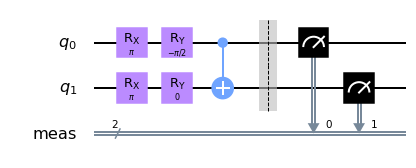

In [3]:
qc = base_circuit([pi, -pi/2], [pi, 0])
qc.draw('mpl')

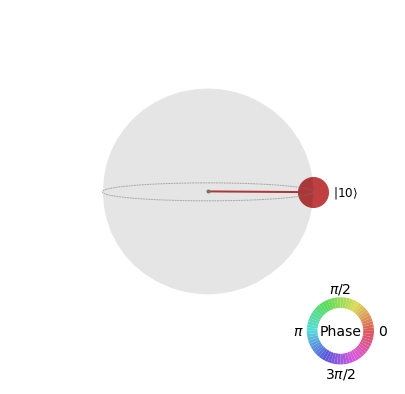

In [4]:
backend = Aer.get_backend('statevector_simulator')
result = execute(qc, backend=backend).result()
plot_state_qsphere(result.get_statevector(qc))

As we can see in the above qsphere, the circuit works! We have an equal superposition of $|01>$ and $|10>$ that is in-phase.

## By-hand implementation of gradient-descent

The basic premise of gradient descent is to have a cost function, which we intend to reduce, and a "gradient" which is nothing but the update in value of the parameter we want to happen, along with a learning rate. The gradient is calculated by taking the derivative of the cost function with respect to the parameter.

To represent cost function, we'll have to use the probability of $|00>, |01>, |10>, |11>$ through counts. Probability can thus simply be the count of that state divided by the total number of counts. We want probabilities of $|01>$ and $|10>$ to be close to 0.5, and $|00>$ and $|11>$ to 0.

$$
J(\theta) = 

(P(|00>) - 0)^2 + 
(P(|01>) - 0.5)^2 + 
(P(|10>) - 0.5)^2 + 
(P(|11>) - 0)^2

$$

Now, to simplify things, we can define a new base circuit _without_ the CNOT gate, so that the end expected state is $|01> + |11>$, which is no more entangled and can simply be written as $(|0> + |1>)\otimes|1>$. Now, we can consider the case of each qubit separately.

We define the new cost function in two parts. For qubit 0, and qubit 1.

$$
J_0(\theta) = (P(|0>) - 0.5)^2 + (P|1> - 0.5)^2
$$
$$
J_1(\theta) = (P|0> - 0)^2 + P(|1> - 1)^2
$$

This makes our mathematical task a lot simpler.

Now, we simply have to use matrices of $R_x(\theta)$ and $R_y(\theta)$ to find out the probability of $|0>$ and $|1>$ appearing after being applied on $|0>$ state.

$$
P(|0>) = cos^2(\frac{\theta_0}{2})cos^2(\frac{\theta_1}{2}) + sin^2(\frac{\theta_0}{2})sin^2(\frac{\theta_1}{2})
$$
$$
P(|1>) = sin^2(\frac{\theta_0}{2})cos^2(\frac{\theta_1}{2}) + cos^2(\frac{\theta_0}{2})sin^2(\frac{\theta_1}{2})
$$

We will now define the gradients of cost of first and second qubit, with respect to either of the thetas.

$$
\frac{\partial J_0}{\partial \theta_0} = sin(\theta_0)cos(\theta_1)(P(|1>)-P(|0>))
$$
$$
\frac{\partial J_0}{\partial \theta_1} = cos(\theta_0)sin(\theta_1)(P(|1>)-P(|0>))
$$
$$
\frac{\partial J_1}{\partial \theta_0} = sin(\theta_0)cos(\theta_1)(P(|1>)-P(|0>)-1)
$$
$$
\frac{\partial J_1}{\partial \theta_1} = cos(\theta_0)sin(\theta_1)(P(|1>)-P(|0>)-1)
$$

Now we will define methods that will return the respective gradients.

In [5]:
def compute_gradient_qubit0(thetas, p0, p1):
    return (np.sin(thetas[0]) * np.cos(thetas[1]) * (p1 - p0), np.cos(thetas[0]) * np.sin(thetas[1]) * (p1 - p0))

def compute_gradient_qubit1(thetas, p0, p1):
    return (np.sin(thetas[0]) * np.cos(thetas[1]) * (p1 - p0 - 1), np.cos(thetas[0]) * np.sin(thetas[1]) * (p1 - p0 - 1))

Also a function to compute the probabilities from the counts

In [6]:
def compute_probabilities(counts, shots):
    try:
        p0 = counts['0'] / shots
    except:
        p0 = 0
    try: 
        p1 = counts['1'] / shots
    except:
        p1 = 0

    return (p0, p1)

And a function to compute cost

In [7]:
def compute_cost_qubit0(p0, p1):
    return (p0-0.5)**2 + (p1-0.5)**2

def compute_cost_qubit1(p0, p1):
    return (p0-0)**2 + (p1-1)**2

Now we'll also have to define a new circuit that only consists of rotations, and not CNOT.

In [8]:
def base_circuit_rotations(thetas):
    """This function defines the base circuit w/ rotations which we'll run our gradient descent algorithm on.
    Args:
        thetas (list): List of thetas of size 2.

    Returns:
        QuantumCircuit: A circuit composed of r_x, and r_y.
    """
    qc = QuantumCircuit(1)
    qc.rx(thetas[0],0)
    qc.ry(q0_thetas[1],0)
    qc.measure_all()
    return qc

Now we define some hyperparameters which can be modified as per our wishes.

In [9]:
# Learning rate (Higher means faster but less accurate, lower means more accurate but slower)
alpha = 0.1

# Number of iterations (higher the better but slower)
iterations = 1000

# Shots for measurement per iterations. We try for 4 different values.
shots = [1, 10, 100, 1000]

# Noise Model. Vigo seems to be the popular choice. See footnote 2.
device_backend = FakeVigo()
noise_model = NoiseModel.from_backend(device_backend)
coupling_map = device_backend.configuration().coupling_map

# Get the basis gates for the noise model
basis_gates = noise_model.basis_gates

# Select the QasmSimulator from the Aer provider
backend = Aer.get_backend('qasm_simulator')

We will now initialize the base circuit with random thetas. (There are somewhat more complicated initilization techniques for ML tasks like He and Xavier, but we won't need that for a simple gradient descent).

We will try to keep the range of values between 0 and $2\pi$ so as to get close to our answer. 

In [10]:
def get_initial_state():
    """Returns randomized initial state of Quantum Circuit w/ rx and ry gate
    Args:
        None

    Returns:
        thetas (List): List of size 2. Randomly generated thetas for qubit_0.       
    """
    thetas = 2*pi*np.random.rand(2)

    return thetas

Now we run the circuit for both qubit 0 and 1.

In the test example, we're running shots of 1, 10, 100, 1000 

and iterations of 1000.

In [11]:
q0_costs = {}
q1_costs = {}
q0_thetas_optimal = {}
q1_thetas_optimal = {}

for each_shot in shots:
    q0_thetas = get_initial_state()
    q1_thetas = get_initial_state()
    
    q0_costs[each_shot] = []
    q1_costs[each_shot] = []
    print("Running {} iterations for {} shots...".format(iterations, each_shot))

    start = time.process_time()
    for i in range(iterations):
        q0_circuit = base_circuit_rotations(q0_thetas)        
        q0_result = execute(q0_circuit, 
                       backend=backend,
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates, 
                       shots=each_shot).result()

        q1_circuit = base_circuit_rotations(q1_thetas)
        q1_result = execute(q1_circuit, 
                       backend=backend,
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates, 
                       shots=each_shot).result()
        
        # Compute probability for q0 and q1
        (q0_p0, q0_p1) = compute_probabilities(q0_result.get_counts(), each_shot)
        q0_cost = compute_cost_qubit0(q0_p0, q0_p1)
        q0_costs[each_shot].append(q0_cost)

        (q1_p0, q1_p1) = compute_probabilities(q1_result.get_counts(), each_shot)
        q1_cost = compute_cost_qubit0(q1_p0, q1_p1)
        q1_costs[each_shot].append(q1_cost)

        q0_grad = compute_gradient_qubit0(q0_thetas, q0_p0, q0_p1)
        q1_grad = compute_gradient_qubit1(q1_thetas, q1_p0, q1_p1)

        q0_thetas = q0_thetas - q0_grad
        q1_thetas = q1_thetas - q1_grad
    print("Done! Took {:.2f} seconds.".format(time.process_time()-start))
    print("---------------------------------------------------------")

    q0_thetas_optimal[each_shot] = q0_thetas
    q1_thetas_optimal[each_shot] = q1_thetas

Running 1000 iterations for 1 shots...
Done! Took 115.33 seconds.
---------------------------------------------------------
Running 1000 iterations for 10 shots...
Done! Took 148.69 seconds.
---------------------------------------------------------
Running 1000 iterations for 100 shots...
Done! Took 151.85 seconds.
---------------------------------------------------------
Running 1000 iterations for 1000 shots...
Done! Took 158.23 seconds.
---------------------------------------------------------


## Results

<small>Note: The slight measurements of |00> and |11> would be due to the noise. While the circuit parameters we obtained are fitting, the noise causes distortions in application of single qubit gates (especially rotation gates, which is what we use here) and multi qubit gates due to decay of entanglement.</small>

#### 1 shot per iteration

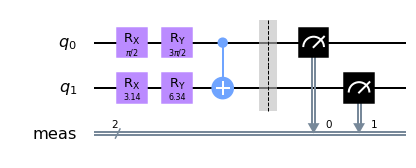

In [12]:
qc = base_circuit(q0_thetas_optimal[1], q1_thetas_optimal[1])
qc.draw('mpl')

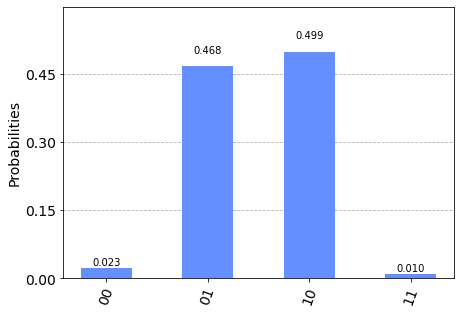

In [13]:
result = execute(qc, 
                backend=backend,
                noise_model=noise_model,
                coupling_map=coupling_map,
                basis_gates=basis_gates, 
                shots=1024).result()

plot_histogram(result.get_counts())

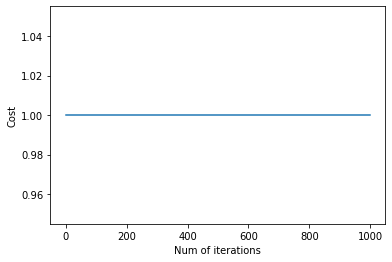

In [44]:
plt.plot([x+y for x,y in zip(q0_costs[1], q1_costs[1])])
plt.ylabel("Cost")
plt.xlabel("Num of iterations")
plt.show()

#### 10 shots per iteration

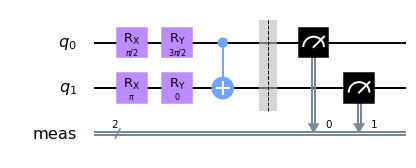

In [14]:
qc = base_circuit(q0_thetas_optimal[10], q1_thetas_optimal[10])
qc.draw('mpl')

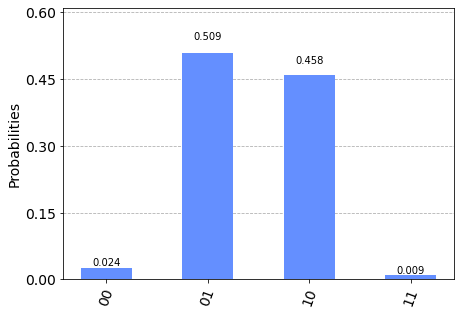

In [15]:
result = execute(qc, 
                backend=backend,
                noise_model=noise_model,
                coupling_map=coupling_map,
                basis_gates=basis_gates, 
                shots=1024).result()

plot_histogram(result.get_counts())

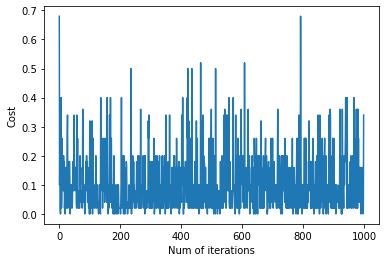

In [53]:
plt.plot([x+y for x,y in zip(q0_costs[10], q1_costs[10])])
plt.ylabel("Cost")
plt.xlabel("Num of iterations")
plt.show()

#### 100 shots per iteration

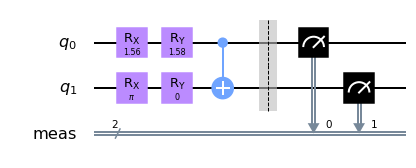

In [16]:
qc = base_circuit(q0_thetas_optimal[100], q1_thetas_optimal[100])
qc.draw('mpl')

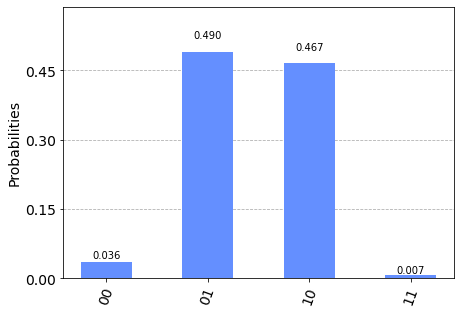

In [17]:
result = execute(qc, 
                backend=backend,
                noise_model=noise_model,
                coupling_map=coupling_map,
                basis_gates=basis_gates, 
                shots=1024).result()

plot_histogram(result.get_counts())

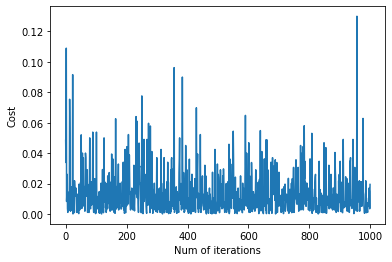

In [54]:
plt.plot([x+y for x,y in zip(q0_costs[100], q1_costs[100])])
plt.ylabel("Cost")
plt.xlabel("Num of iterations")
plt.show()

#### 1000 shots per iteration

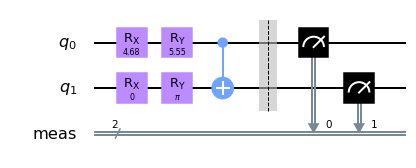

In [18]:
qc = base_circuit(q0_thetas_optimal[1000], q1_thetas_optimal[1000])
qc.draw('mpl')

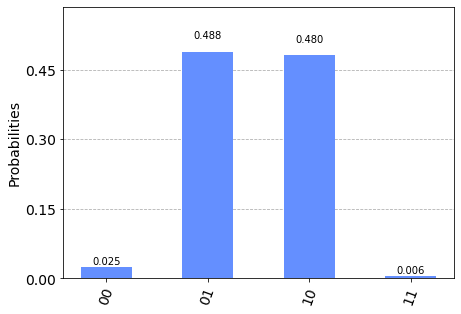

In [19]:
result = execute(qc, 
                backend=backend,
                noise_model=noise_model,
                coupling_map=coupling_map,
                basis_gates=basis_gates, 
                shots=1024).result()

plot_histogram(result.get_counts())

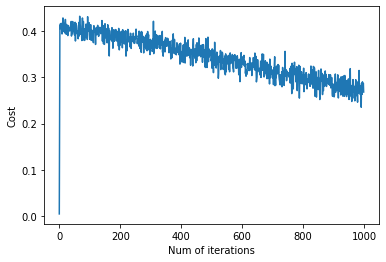

In [55]:
plt.plot([x+y for x,y in zip(q0_costs[1000], q1_costs[1000])])
plt.ylabel("Cost")
plt.xlabel("Num of iterations")
plt.show()

## Observations

We can see that the number of shots does not seem to have any observable impact on the desired outcome. This is very possibly due to the huge number of iterations (=1000) that we have made which point the parametric angles into the right direction. the The probabilities of $|01>$ and $|10>$ are more or less the same, although $|00>$ and $|11>$ also appear due to noise.

It should be noted that by placing the probabilities as the measure for desired state, we ignore the relative phases induced due to the rotation gates. Indeed, this is the problem at hand of the bonus question.

## Noiseless simulations

Why? 

I just think it'd be interesting to see how the existence of noise is affecting the time required for reaching the optimal solution. We'll basically use the same circuit as before but just remove the noise model (and coupling map and basis gates).

In [20]:
q0_costs_noiseless = {}
q1_costs_noiseless = {}
q0_thetas_optimal_noiseless = {}
q1_thetas_optimal_noiseless = {}

for each_shot in shots:
    q0_thetas = get_initial_state()
    q1_thetas = get_initial_state()
    
    q0_costs_noiseless[each_shot] = []
    q1_costs_noiseless[each_shot] = []
    print("Running {} iterations for {} shots...".format(iterations, each_shot))

    start = time.process_time()
    for i in range(iterations):
        q0_circuit = base_circuit_rotations(q0_thetas)        
        q0_result = execute(q0_circuit, 
                       backend=backend,
                       shots=each_shot).result()

        q1_circuit = base_circuit_rotations(q1_thetas)
        q1_result = execute(q1_circuit, 
                       backend=backend,
                       shots=each_shot).result()
        
        # Compute probability for q0 and q1
        (q0_p0, q0_p1) = compute_probabilities(q0_result.get_counts(), each_shot)
        q0_cost = compute_cost_qubit0(q0_p0, q0_p1)
        q0_costs_noiseless[each_shot].append(q0_cost)

        (q1_p0, q1_p1) = compute_probabilities(q1_result.get_counts(), each_shot)
        q1_cost = compute_cost_qubit0(q1_p0, q1_p1)
        q1_costs_noiseless[each_shot].append(q1_cost)

        q0_grad = compute_gradient_qubit0(q0_thetas, q0_p0, q0_p1)
        q1_grad = compute_gradient_qubit1(q1_thetas, q1_p0, q1_p1)

        q0_thetas = q0_thetas - q0_grad
        q1_thetas = q1_thetas - q1_grad
    print("Done! Took {:.2f} seconds.".format(time.process_time()-start))
    print("---------------------------------------------------------")

    q0_thetas_optimal_noiseless[each_shot] = q0_thetas
    q1_thetas_optimal_noiseless[each_shot] = q1_thetas

Running 1000 iterations for 1 shots...
Done! Took 25.64 seconds.
---------------------------------------------------------
Running 1000 iterations for 10 shots...
Done! Took 25.23 seconds.
---------------------------------------------------------
Running 1000 iterations for 100 shots...
Done! Took 26.88 seconds.
---------------------------------------------------------
Running 1000 iterations for 1000 shots...
Done! Took 33.30 seconds.
---------------------------------------------------------


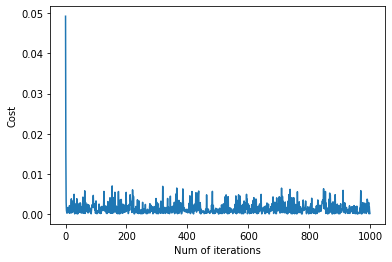

In [60]:
plt.plot([x+y for x,y in zip(q0_costs_noiseless[1000], q1_costs_noiseless[1000])])
plt.ylabel("Cost")
plt.xlabel("Num of iterations")
plt.show()

Phew.

This reduced the time required for iterations by ~80%. So far as I understand, this is not because the model is approaching the optimal value earlier. While it's safe to assume that due to the noiseless simulations we reach the optimal solution earlier, the number of FLOPs (Floating point operations) are still the same (same number of iterations), albeit they're being done with a bunch of `0` values. 

Where I think this matters is that when applying the gates and measurement, the existence of noise causes a delay in the execution of circuit. This can be checked by running a simple entangled circuit.

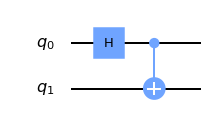

In [26]:
# Create 00 + 11

qc_try = QuantumCircuit(2)
qc_try.h(0)
qc_try.cx(0,1)
qc.measure_all()
qc_try.draw('mpl')

In [27]:
start = time.process_time()
result = execute(qc_try, 
                backend=backend,
                noise_model=noise_model,
                coupling_map=coupling_map,
                basis_gates=basis_gates, 
                shots=1024).result()
print("Done! Took {:f} seconds.".format(time.process_time()-start))

Done! Took 0.075012 seconds.


In [30]:
start = time.process_time()
result = execute(qc_try, 
                backend=backend,
                # noise_model=noise_model,
                coupling_map=coupling_map,
                basis_gates=basis_gates, 
                shots=1024).result()
print("Done! Took {:f} seconds.".format(time.process_time()-start))

Done! Took 0.012860 seconds.


Turns out, my hypothesis is correct. We got a speed boost by removing noise while keeping the same basis gates and coupling map.

This would be especially aggravated in a situation where we are performing 1000s of iterations and 100s of shots.

## Bonus Question

It is an interesting question since we have to ensure that the relative phase of the qubits remains in-phase (that is, both of them have the same relative phase, since global phase gets ignored anyways). We can see in the obtained optimal values of theta that they're not exactly the ones we wanted, but are inducing a relative phase, which is not observed in counts / probabilities. To achieve this, using our heuristic of unentangled states, we'd have to ensure that the sequence of $R_x$ and $R_y$ gates applied on qubit 0 act in the following manner.

$$ 
U|0> = |0> + |1> 
$$

A careful inspection of what's happening here would tell us that this is acting exactly like a Hadamard gate. Therefore, we want the sequence of gates to be acting like Hadamard.

## Footnotes

1. Qiskit 1-minute tutorial on qsphere https://www.youtube.com/watch?v=4SoK2h4a7us
2. Qiskit Noise Simulation https://qiskit.org/documentation/tutorials/simulators/2_device_noise_simulation.html

## References

1. Andrew Ng, Machine Learning
2. Qiskit textbook